## Dateframe Optimisation

**This notebook shos how reduce the memory footprint of a pandas dataframe thus speeding up training times without loss of performance.  It can be found on my kaggle page, details given below**


This uses the DonorsChose.org dataset 
- https://www.kaggle.com/richarde/random-forest-with-50-reduction-in-training-time/data


Little attention is given to the actual types of data contained in pandas dataframes and how they can affect performance.
But by carrying out some simple optimisations, training times can be dramatically reduced - in this example by 50%

In this short notebook i will:
1. Discuss the datatypes
2. Show how to determine and reduce the memory footprint of a dataframe
3. Run a normal and reduced memory footprint dataframe using a Random Forest algorithm with associated parameters and compare the execution times

This is not an optimal machine learning solution - but using similar techniques it should be possible to reduce your training times.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
train = pd.read_csv('train.csv', parse_dates=['project_submitted_datetime'])
test = pd.read_csv('test.csv', parse_dates=['project_submitted_datetime'])
resources = pd.read_csv('resources.csv')
#submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head(1)
resources.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


For demonstration purposes we select some data from the train and resources data.  Also add a new feature  

In [4]:
mem_df1 = train[['id','teacher_id','teacher_number_of_previously_posted_projects','project_is_approved']]
resources['total_cost'] = resources['quantity']*resources['price']
mem_df2 = resources[['id','quantity','price','total_cost']]

In [5]:
train_mem = pd.merge(mem_df1,mem_df2,how='left',on='id')
train_mem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081830 entries, 0 to 1081829
Data columns (total 7 columns):
id                                              1081830 non-null object
teacher_id                                      1081830 non-null object
teacher_number_of_previously_posted_projects    1081830 non-null int64
project_is_approved                             1081830 non-null int64
quantity                                        1081830 non-null int64
price                                           1081830 non-null float64
total_cost                                      1081830 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 66.0+ MB


We can see that we have strings, integers and floats.  Here we will concentrate on the numeric datatypes.  For the integer types what are the actual ranges?

In [6]:
#some examples of datatypes unsigned and signed
data_types = ["uint8","int8","int16","uint16","uint64","int64"]
for it in data_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

Machine parameters for uint64
---------------------------------------------------------------
min = 0
max = 18446744073709551615
---------------------------------------------------------------

Machine parameters for int64
-------------------------------------------------------------

We can see in our dataframe we have three int64 datatypes, do we really need such a size? Lets check  

In [7]:
train_mem.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,total_cost
count,1.081830e+06,1.081830e+06,1.081830e+06,1.081830e+06,1.081830e+06
mean,1.254963e+01,7.923777e-01,2.856420e+00,5.011038e+01,9.185359e+01
std,3.038872e+01,4.056050e-01,7.529482e+00,1.431715e+02,2.359322e+02
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,1.000000e+00,7.870000e+00,1.057000e+01
50%,3.000000e+00,1.000000e+00,1.000000e+00,1.499000e+01,2.533000e+01
75%,1.000000e+01,1.000000e+00,2.000000e+00,3.964000e+01,7.250000e+01
max,4.510000e+02,1.000000e+00,8.000000e+02,9.999000e+03,1.234400e+04


We can see that teacher_number_of_previously_posted_projects ranges from 0 to 451, project_is_approved ranges for 0 to 1 and quantity ranges from 1 to 9999.  Lets select and convert the integer types using a simple function to see how much memory we could save: 

In [8]:
def mem_usage(pandas_obj):
    usage_b = pandas_obj.memory_usage(deep=True).sum()
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

train_mem_int = train_mem.select_dtypes(include=['int64'])
converted_int = train_mem_int.apply(pd.to_numeric,downcast='unsigned')

print("Size of integer types before {}".format(mem_usage(train_mem_int)))
print("Size of integer types after {}".format(mem_usage(converted_int)))

compare_ints = pd.concat([train_mem_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['No. of types before','No. of types after']
compare_ints.apply(pd.Series.value_counts)

Size of integer types before 33.01 MB
Size of integer types after 13.41 MB


,No. of types before,No. of types after
uint8,NaN,1.0
uint16,NaN,2.0
int64,3.0,NaN


Lets repeat this for the float columns

In [9]:
train_mem_float = train_mem.select_dtypes(include=['float'])
converted_float = train_mem_float.apply(pd.to_numeric,downcast='float')

print("Size of float types before: {}".format(mem_usage(train_mem_float)))
print("Size of float types after: {}".format(mem_usage(converted_float)))

compare_floats = pd.concat([train_mem_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['No. of types before','No. of types after']
compare_floats.apply(pd.Series.value_counts)

Size of float types before: 24.76 MB
Size of float types after: 16.51 MB


,No. of types before,No. of types after
float32,NaN,2.0
float64,2.0,NaN


Ok, lets try a simple gridsearch using random forest on the ORIGINAL datatype dataframe

In [10]:
X = train_mem.drop(['id', 'project_is_approved','teacher_id'], axis=1)
y = train_mem['project_is_approved']
print(X.dtypes)
print(" ")
print(y.dtypes)

teacher_number_of_previously_posted_projects      int64
quantity                                          int64
price                                           float64
total_cost                                      float64
dtype: object
 
int64


In [11]:
num_folds = 5
seed = 7
scoring = 'accuracy'

start = time.time()
param_grid = {'max_depth': [5,8],
              'min_samples_split':[3,5]
             }

model = RandomForestClassifier(n_jobs=-1)
kfold =KFold(n_splits = num_folds,random_state = seed)
grid = GridSearchCV(estimator = model,param_grid = param_grid,scoring=scoring,cv=kfold)
grid_result = grid.fit(X,y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))
time_first = end - start

Best: 0.792378 using {'max_depth': 5, 'min_samples_split': 3}
Time taken in grid search:  53.51


Lets replace the int and float datatypes with the values calculated above

In [12]:
columns_to_overwrite_float = ['total_cost','price']
train_mem.drop(labels=columns_to_overwrite_float, axis="columns", inplace=True)
train_mem[columns_to_overwrite_float] = converted_float[columns_to_overwrite_float]

In [13]:
columns_to_overwrite_int = ['teacher_number_of_previously_posted_projects','project_is_approved','quantity']
train_mem.drop(labels=columns_to_overwrite_int, axis="columns", inplace=True)
train_mem[columns_to_overwrite_int] = converted_int[columns_to_overwrite_int]

In [19]:
converted_int[:10]

,teacher_number_of_previously_posted_projects,project_is_approved,quantity
0,26,1,3
1,26,1,3
2,1,0,20
3,5,1,1
4,16,0,1
5,16,0,1
6,16,0,1
7,16,0,1
8,16,0,1
9,42,1,2


In [20]:
train_mem_after = train_mem.copy(deep=True)
train_mem_after.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1081830 entries, 0 to 1081829
Data columns (total 7 columns):
id                                              1081830 non-null object
teacher_id                                      1081830 non-null object
total_cost                                      1081830 non-null float32
price                                           1081830 non-null float32
teacher_number_of_previously_posted_projects    1081830 non-null uint16
project_is_approved                             1081830 non-null uint8
quantity                                        1081830 non-null uint16
dtypes: float32(2), object(2), uint16(2), uint8(1)
memory usage: 38.2+ MB


This new dataframe has a memory usage of 38 MB down from 66MB in the original

In [16]:
X = train_mem_after.drop(['id', 'project_is_approved','teacher_id'], axis=1)
y = train_mem_after['project_is_approved']
print(X.dtypes)
print(" ")
print(y.dtypes)

total_cost                                      float32
price                                           float32
teacher_number_of_previously_posted_projects     uint16
quantity                                         uint16
dtype: object
 
uint8


In [17]:
start = time.time()

param_grid = {'max_depth': [5,8],
              'min_samples_split':[3]
             }
model = RandomForestClassifier(n_jobs=-1)
kfold =KFold(n_splits = num_folds,random_state = seed)
grid = GridSearchCV(estimator = model,param_grid = param_grid,scoring=scoring,cv=kfold)
grid_result = grid.fit(X,y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))
time_second = end - start

Best: 0.792378 using {'max_depth': 5, 'min_samples_split': 3}
Time taken in grid search:  27.63


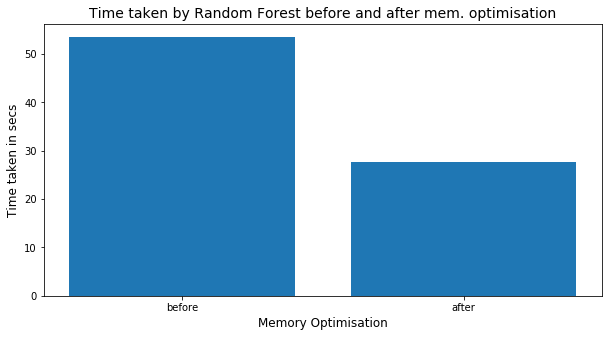

In [18]:
plt.figure(figsize=(10,5))
x_pos = [0,1]
x_label= ['before','after']
scores = [time_first,time_second]
plt.bar(x_pos,scores,align='center')
plt.xlabel('Memory Optimisation',fontsize=12)
plt.xticks(x_pos,x_label)
plt.ylabel('Time taken in secs',fontsize=12)
plt.title('Time taken by Random Forest before and after mem. optimisation',fontsize=14)
plt.show();

**We have reduced our training time by approximately 50% and still achieved the same accuracy score**

This simple example has demonstrated that by having greater understanding of the underlying data, it is possible to reduce the required processing times without any degradation in performance. 

If you found this notebook interesting please upvote it!